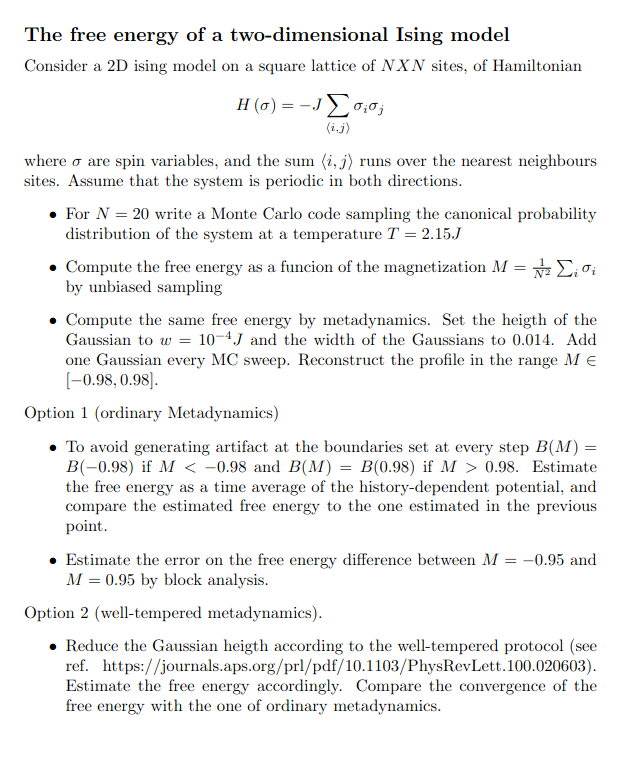

In [8]:
import numpy as np
%matplotlib widget
import matplotlib.pyplot as plt
from tqdm import tqdm

In [9]:
# Define parameters 
N = 20 # Number of sites along one dimension
J = 1 # Coupling constant
kbT = 2.15*J # Temperature
n_steps = 10000 # Default number of time steps

In [10]:
# Define the Hamiltonian
def H(spins, J):
    ''' Returns the Hamiltonian of the system. It is computed as the sum of the interactions between nearest neighbours. '''
    # Compute interaction with each neighbour in a parallelised fashion by matrices element-wise multiplication. np.roll accounts for PBCs.
    H = spins*np.roll(spins,1, axis=1) + spins*np.roll(spins,-1, axis=1) + spins*np.roll(spins,-1, axis=0) + spins*np.roll(spins,1, axis=0)
    return -J*H/2 # We divide to avoid double counting

# Define magnetisation
def M_compute(spins):
    ''' Returns the total magnetisation of the system, divided by the number of sites. '''
    return np.sum(spins)/N**2

In [11]:
# Metadynamics params
w = 1e-4*J # Height of the Gaussian
width = 0.014 # Width of the Gaussian
M_domain = np.linspace(-1,1,N**2 + 1, endpoint=True) # Domain of the magnetisation

In [12]:
def add_gaussian(bias,M,w,width):
    ''' Adds a Gaussian centered on M to the bias potential. '''
    # Compute gaussian centered on M on each point of the domain of M
    gaussian = w*np.exp(-(M_domain-M)**2/(2*width**2))
    # Add the Gaussian to the bias potential
    bias += gaussian
    return bias

def get_bias_index(M):
    ''' Returns the index of the bias potential corresponding to the magnetisation M. '''
    # We need to map the magnetization domain to integers. To do so the lowest posible magnetization is associated to 0, the highest to N**2+1
    return np.round((M*N**2 + N**2)/2).astype(int)

def get_bias(bias,M):
    ''' Returns the bias potential for a given magnetisation. '''
    M_index = get_bias_index(M)
    return bias[M_index]

def propose_single_move(spins):
    '''Optimised version of propose move for spins_flip_per_step == 1'''
    ix, iy = np.random.randint(N,size=2)
    delta_E = 2*spins[ix,iy]*(spins[ix,(iy+1)%N] + spins[ix,(iy-1)%N] + spins[(ix+1)%N,iy] + spins[(ix-1)%N,iy])
    delta_M = -2*spins[ix,iy]/N**2
    return (ix,iy), delta_E, delta_M

def propose_move(spins, spins_flip_per_step):
    '''Proposes a move by flipping random spins. Number of spins flipped is given by spins_flip_per_step.
     Returns the proposed spins, energy and magnetisation. '''
    if spins_flip_per_step == 1:
        # Optimised version for spins_flip_per_step == 1
        return propose_single_move(spins)
 
    proposed_spins = spins.copy()
    # Randomly choose the spins to flip
    # Generate N couples of random integers between 0 and N-1
    ijs = np.random.randint(N, size=(spins_flip_per_step,2))
    for i,j in ijs:
        proposed_spins[i,j] *= -1
    
    # Compute the new energy and magnetisation
    delta_E = np.sum(H(proposed_spins, J)) - np.sum(H(spins, J))
    delta_M = M_compute(proposed_spins) - M_compute(spins)
    return ijs, delta_E, delta_M

def initialize(metadynamics, bias, spins, M_time_series):
    ''' Initializes the E_0, M, M_time_series and bias. If metadynamics is True, initializes the bias potential. '''
    if metadynamics:
        # Raise error if only one is given between bias and spins
        if (bias is None) != (spins is None) != (M_time_series is None):
            raise ValueError('If metadynamics is True, both bias and spins must be given or none of them.')
    
    if spins is None:
        spins = np.random.choice([-1,1], size=(N,N)) # Random initial configuration
    
    M = M_compute(spins) # Initial magnetisation
    if M_time_series is None:
        M_time_series = [ M_compute(spins), ] # List to store the magnetisation at each time step
    elif type(M_time_series) == np.ndarray:
        M_time_series = list(M_time_series)
    
    E_0 = np.sum(H(spins, J)) # Initial energy
    # initialize bias potential
    if metadynamics:
        if bias is None:    # If no bias is given, initialize it to zero. Otherwise, use the given initial condition. Useful for continuing a simulation
            bias = np.zeros(N**2+1) # Bias potential as a function of magnetisation
    return spins, E_0, M, M_time_series, bias


def run_simulation(n_steps, spins = None, metadynamics = True, spins_flip_per_step = 1, bias = None, M_time_series = None):
    ''' Runs a simulation of Metropolis MC. If metadynamics is True, runs a bias is added to at each step.'''

    # Initialize the following variables
    spins, E_0, M, M_time_series, bias = initialize(metadynamics, bias, spins, M_time_series)
    
    # Metropolis
    acceptance = 0
    for i_step in tqdm(range(n_steps)):
        # Move is proposed by flipping some random spins
        proposed_spin_position, delta_E, delta_M = propose_move(spins, spins_flip_per_step)
        
        # Compute the acceptance
        # Acceptance computed as ratio of probabilities. Proposal matrix is symmetric, so it cancels out
        if metadynamics: 
            alpha = min(1, np.exp(-(delta_E+get_bias(bias,M + delta_M)-get_bias(bias,M))/kbT))
        else:
            alpha = min(1, np.exp(-delta_E/kbT))

        # Accept or reject the move
        if np.random.random() < alpha:  # Accept. We avoid the edges of the domain.
            # Update the variables
            if spins_flip_per_step == 1:
                spins[proposed_spin_position[0], proposed_spin_position[1]] *= -1
            else:
                for i,j in proposed_spin_position:
                    spins[i,j] *= -1
            E_0 += delta_E
            M += delta_M
            acceptance += 1
        else: # Reject
            pass
        
        if metadynamics:
            # Update bias for each spin
            bias = add_gaussian(bias,M,w,width)

            # Avoid biasing the edges of the domain. We set B[<-0.98]=B[-0.98] and B[>0.98]=B[0.98]
            bias[:get_bias_index(-0.98)] = bias[get_bias_index(-0.98)]
            bias[get_bias_index(0.98):] = bias[get_bias_index(0.98)]

        # assert from time to time that M and E are correct, since we only compute increments
        if i_step % 1000 == 0:
            assert np.isclose(M, M_compute(spins))
            assert np.isclose(E_0, np.sum(H(spins, J)))
        # We save the magnetisation every 100 steps
        if i_step % 100 == 0:
            M_time_series.append(M)
        
    print('Acceptance rate: {:.2f}%'.format(100*acceptance/n_steps))

    # String is empty if metadynamics is True, otherwise it is '_unbiased'
    additional_string = '' if metadynamics else '_unbiased'
    np.savetxt(f'final_spins{additional_string}.txt', spins)
    np.savetxt(f'M_time_series{additional_string}_partial.txt', M_time_series)
    if metadynamics: np.savetxt('bias.txt', bias)    

    return M_time_series, bias, spins


In [75]:
# Define bins of histogram such that everyone contains one value of M. each bin will be centered around a value of M and be of width 2/N**2
bin_edges_of_M_domain = np.linspace(-1-1/N**2,1+1/N**2,N**2+2)
def run_multiple_simulations(n_simulations, n_steps, spins = None, metadynamics = True, spins_flip_per_step = 1, bias = None, continue_last_simulation = True):
    ''' Runs multiple simulations and plots the bias potential at the end of each simulation. '''

    # String is empty if metadynamics is True, otherwise it is '_unbiased'
    additional_string = '' if metadynamics else '_unbiased'

    # If continue_last_simulation is True, we load the last configuration of the spins, the bias potential and the magnetisation time series
    # If continue_last_simulation is False, we start from scratch
    # If the variables are given as input, we use them instead of loading them from file
    if spins is None and continue_last_simulation:
        spins = np.loadtxt(f'final_spins{additional_string}.txt')
    if bias is None and continue_last_simulation and metadynamics:
        bias = np.loadtxt('bias.txt')

    # Let's plot the evolution of the bias potential.
    # To do so we launch consecutive simulations in loop and plot the bias potential at the end of each simulation.
    if metadynamics:
        plt.figure()
        plt.title('Bias potential')
        plt.xlabel('Magnetisation')
        plt.ylabel('Bias potential')
    if metadynamics: plt.gca().invert_yaxis()
    for i_sim in range(n_simulations):
        M_time_series, bias, spins = run_simulation(n_steps=n_steps, spins=spins, metadynamics=metadynamics, spins_flip_per_step=spins_flip_per_step, bias=bias)
        # Plot the new bias potential with the previous ones
        if metadynamics:
            plt.plot(M_domain, bias, label = 'Sim. {}'.format(i_sim))
            plt.legend()
            plt.savefig('bias_potential.png')
            # Save the time series after the previous simulations. Precision is 3 digits after the decimal point.
        print('Completed simulation {}/{}'.format(i_sim+1, n_simulations))
        np.savetxt(f'M_time_series{additional_string}.txt', np.concatenate((np.loadtxt(f'M_time_series{additional_string}.txt'), np.array(M_time_series))))

Metadynamics

100%|██████████| 1000000/1000000 [01:50<00:00, 9040.70it/s]


Acceptance rate: 15.18%


100%|██████████| 1000000/1000000 [01:49<00:00, 9171.31it/s]


Acceptance rate: 15.15%


100%|██████████| 1000000/1000000 [01:44<00:00, 9536.40it/s]


Acceptance rate: 17.63%


100%|██████████| 1000000/1000000 [01:46<00:00, 9357.11it/s]


Acceptance rate: 18.97%


100%|██████████| 1000000/1000000 [02:09<00:00, 7699.29it/s]


Acceptance rate: 18.84%


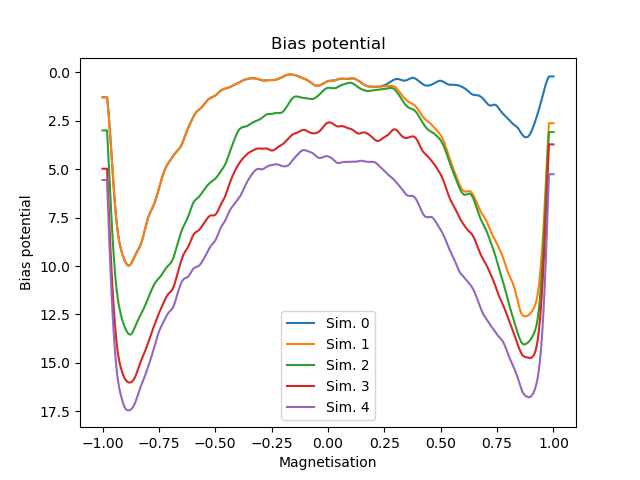

In [93]:
continue_last_simulation = True
n_simulations = 5
n_steps = int(1e6)
metadynamics = True

# Run the simulation
M_time_series = run_multiple_simulations(n_simulations=n_simulations, n_steps=n_steps, metadynamics=metadynamics, continue_last_simulation=continue_last_simulation)

Unbiased simulation

In [101]:
continue_last_simulation = True
n_simulations = 5
n_steps = int(1e7)
metadynamics = False

# Run the simulation
run_multiple_simulations(n_simulations=n_simulations, n_steps=n_steps, metadynamics=metadynamics, continue_last_simulation=continue_last_simulation)

100%|██████████| 10000000/10000000 [06:33<00:00, 25442.17it/s]


Acceptance rate: 12.88%


100%|██████████| 10000000/10000000 [06:35<00:00, 25313.02it/s]


Acceptance rate: 12.68%


100%|██████████| 10000000/10000000 [06:38<00:00, 25121.59it/s]


Acceptance rate: 12.70%


100%|██████████| 10000000/10000000 [06:05<00:00, 27359.12it/s]


Acceptance rate: 12.73%


100%|██████████| 10000000/10000000 [07:20<00:00, 22702.03it/s]


Acceptance rate: 13.01%


Let's compare the results obtained with classic MD and metadynamics

In [102]:
# Plot F estimate for unbiased MD:
M_time_series_unbiased = np.loadtxt('M_time_series_unbiased.txt')


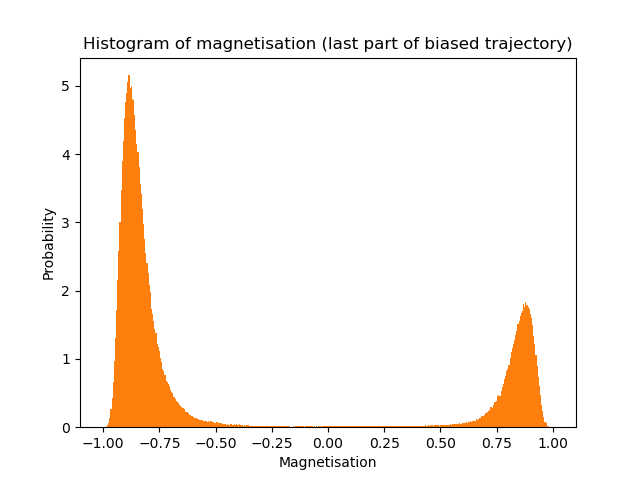

In [109]:
# Plot the free energy from the unbiased simulation
plt.close()
plt.hist(M_time_series_unbiased, bins= bin_edges_of_M_domain, density=True)
plt.show()
bias = np.loadtxt('bias.txt')


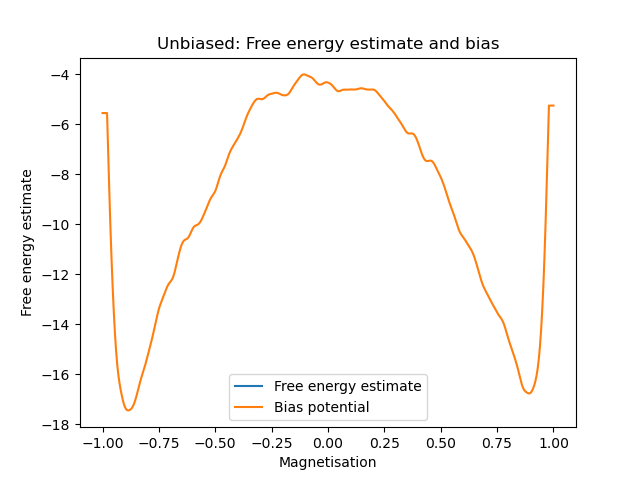

In [104]:
plt.figure()
plt.title('Unbiased: Free energy estimate and bias')
plt.xlabel('Magnetisation')
plt.ylabel('Free energy estimate')
plt.plot(bin_centers, free_energy, label = 'Free energy estimate')
# Plot bias
plt.plot(M_domain, -bias, label = 'Bias potential')
plt.legend()

plt.show()


In [105]:
M_time_series = np.loadtxt('M_time_series.txt')

/home/gsacco/anaconda3/envs/mdaenv/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


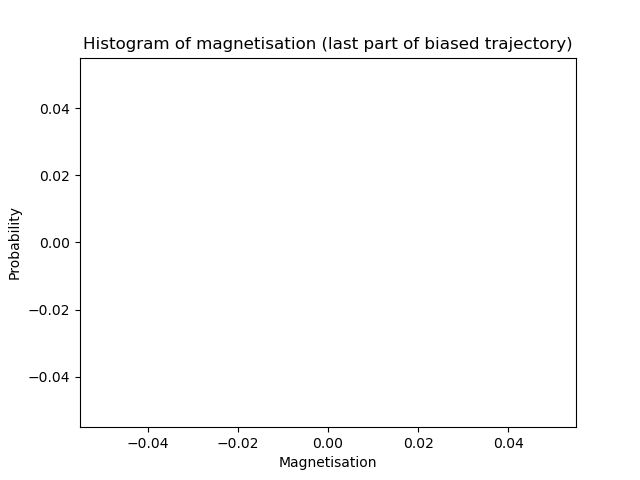

In [106]:
# Let's see the histrogram of the last part of biased trajectory, we expect it to be approximately flat
plt.figure()
plt.title('Histogram of magnetisation (last part of biased trajectory)')
plt.xlabel('Magnetisation')
plt.ylabel('Probability')
plt.hist(M_time_series[:-int(2e4)], bins=100, density=True)
plt.show()

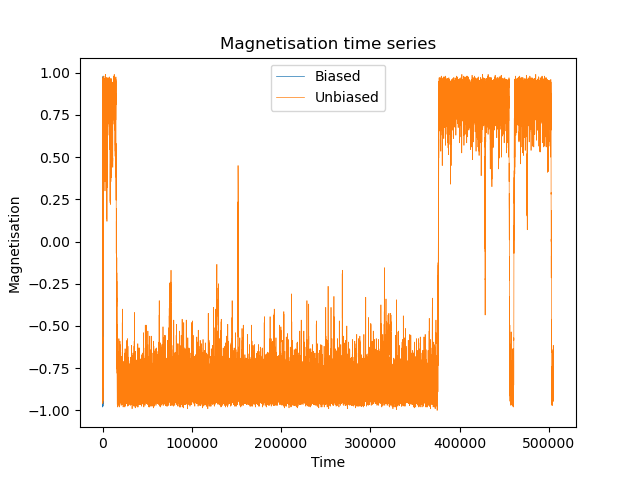

In [107]:
# Let's look at the trajectories of the magnetisation
plt.figure()
plt.title('Magnetisation time series')
plt.xlabel('Time')
plt.ylabel('Magnetisation')
plt.plot(M_time_series, label = 'Biased', linewidth=0.5)
plt.plot(M_time_series_unbiased, label = 'Unbiased', linewidth=0.5)
# Multiply xlabels by 10000 to get time in steps
plt.legend()
plt.show()

In [108]:
# Decimate the time series files to reduce their size
np.savetxt('M_time_series.txt', M_time_series[::100])
np.savetxt('M_time_series_unbiased.txt', M_time_series_unbiased[::100])